This notebook studies the applicability of b/c-tagging event vetoes on background samples.

For 102x, [central Btag recommendations](https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X) provide working points for DeepCSV and DeepFlavour.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
datasets_=json.load(open('../Samples/backgrounds_nonempty.json'))
scales_=json.load(open('../Samples/backgrounds_scale.json'))

# flatten datasets
datasets = {}
for group in datasets_:
    for tag in datasets_[group]:
        files = datasets_[group][tag]
        datasets[tag] = {'files': files, 'treename': 'ffNtuples/ffNtuple'}
        if tag=='TTJets': datasets[tag]['treename'] = 'ffNtuplizer/ffNtuple'

# flatten scales
scales = {}
for group in scales_:
    for tag in scales_[group]:
        scales[tag] = scales_[group][tag]

lumi = 60.432*1e3
for k in scales:
    scales[k] *= lumi

# mapping
mapping = {}
for k in datasets_: mapping[k] = list(datasets_[k])

**b tagger**

|       | loose | medium | tight |
|-------|-------|--------|-------|
|DeepCSV|0.1241 | 0.4184 | 0.7527|
|DeepJet|0.0494 | 0.2770 | 0.7264|

In [3]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        quality_axis = hist.Cat('wp', 'working points')
        multiplicity_axis = hist.Bin('multi', '#b-tagged/event', 6, 0, 6)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist('A.U.', dataset_axis, quality_axis, multiplicity_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        deepcsv_b = df['hftagscore_DeepCSV_b']
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        deepcsv_b = deepcsv_b[metfiltermask]
        
        output['multi'].fill(dataset=dataset, wp='loose', multi=deepcsv_b[deepcsv_b>0.1241].counts)
        output['multi'].fill(dataset=dataset, wp='medium', multi=deepcsv_b[deepcsv_b>0.4184].counts)
        output['multi'].fill(dataset=dataset, wp='tight', multi=deepcsv_b[deepcsv_b>0.7527].counts)
        
        return output
    
    def postprocess(self, accumulator):
        # scale
        accumulator['multi'].scale(scales, axis='dataset')
        # cat grouping
        accumulator['multi_cat'] = accumulator['multi'].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2821/2821 [01:58<00:00, 23.84items/s]


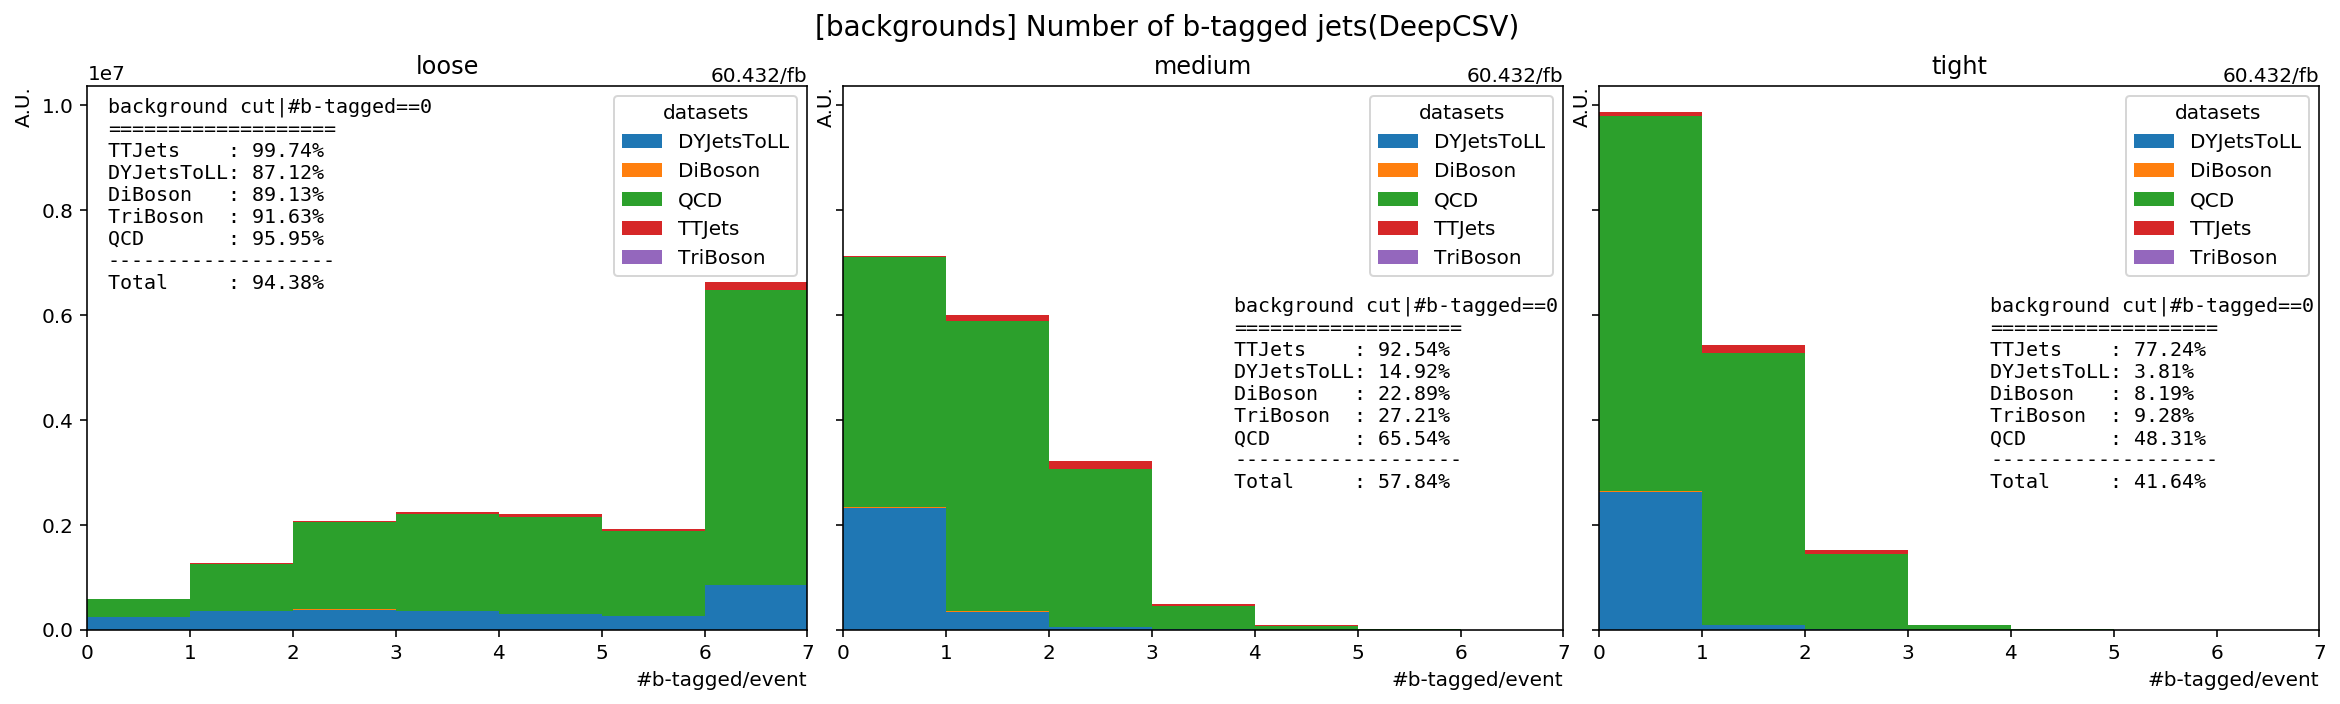

In [22]:
fig, _ = plt.subplots(1,3,figsize=(20,5), gridspec_kw={'wspace': 0.05}, sharey=True)
fig, axes = hist.plotgrid(output['multi_cat'], figure=fig, col='wp', overlay='cat', stack=True, overflow='over',)
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
plt.suptitle('[backgrounds] Number of b-tagged jets(DeepCSV)', fontsize=14)

# print background cut
from collections import defaultdict
res = defaultdict(dict)
ressum = dict()
for c, vals in output['multi_cat'].values().items():
    loss = 1-vals[0]/np.sum(vals)
    res[c[1]][c[0]] = loss
for c, val in output['multi_cat'].sum('cat').values().items():
    ressum[c[0]] = 1-val[0]/np.sum(val)

restext = {}
for wp in res:
    text_ = ['background cut|#b-tagged==0','='*19]
    for x, v in res[wp].items():
        text_.append("{:10}: {:.2%}".format(x, v))
    text_.append('-'*19)
    text_.append("{:10}: {:.2%}".format("Total", ressum[wp]))
    restext[wp] = '\n'.join(text_)
axes[0][0].text(0.2, 0.65e7, restext['loose'], family='monospace')
axes[0][1].text(3.8, 0.27e7, restext['medium'], family='monospace')
axes[0][2].text(3.8, 0.27e7, restext['tight'], family='monospace');